In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# dataset from https://www.kaggle.com/moltean/fruits/data
data_dir = '/media/carloalberto/DATASETS/fruits-360'

image_datasets = {x: datasets.ImageFolder(
                                os.path.join(data_dir, x), 
                                transform=data_transforms[x]
                     )
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(
                                image_datasets[x], batch_size=4,
                                shuffle=True, num_workers=4
                  )
            for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print("Classes: ")
print(image_datasets['train'].classes)

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Classes: 
['Apple Braeburn', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 'Carambula', 'Cherry', 'Clementine', 'Cocos', 'Dates', 'Granadilla', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kiwi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Litchi', 'Mandarine', 'Mango', 'Maracuja', 'Nectarine', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Peach Flat', 'Pear', 'Pear Abate', 'Pear Monster', 'Pear Williams', 'Pepino', 'Pineapple', 'Pitahaya Red', 'Plum', 'Pomegranate', 'Quince', 'Raspberry', 'Salak', 'Strawberry', 'Tamarillo', 'Tangelo']
Using CUDA


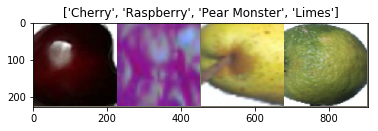

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])
    del inputs, classes

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
show_databatch(inputs, classes)

In [3]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.train(False)
    model.eval() # Set model for evaluation
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        print("BATCH {0}".format(i))
        inputs, labels = data
        size = inputs.size()[0]
        # print(labels)
        
        if use_gpu:
            print("Using CUDA")
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = model(inputs)
        # print(outputs)
        
        # outputs.cpu()
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        # print(labels)
        # print(predicted_labels)
        
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        # grid = torchvision.utils.make_grid(inputs.data)
        # imshow(grid, title=[class_names[preds[j]] for j in range(inputs.size()[0])])
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    model.train(mode=was_training) # Revert model back to original training state

In [4]:
model = models.vgg16_bn(pretrained='imagenet')

# Replace last FC layer to fit data classes
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Convert classifier layers to list
features.extend([nn.Linear(num_features, len(class_names))]) # Extend list with our custom layer
model.classifier = nn.Sequential(*features) # Replace model classifier

if use_gpu:
    model.cuda()

In [5]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Test before training
BATCH 0
Using CUDA
Ground truth:


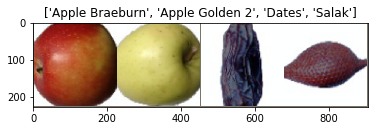

Prediction:


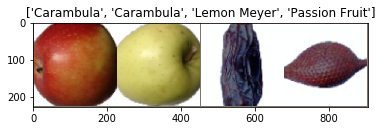

BATCH 1
Using CUDA
Ground truth:


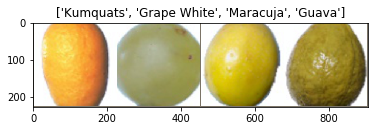

Prediction:


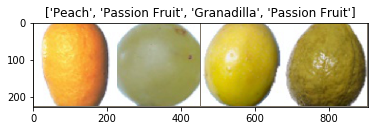

In [6]:
print("Test before training")
visualize_model(model) #test before training

In [7]:
from livelossplot import PlotLosses

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = None #copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    liveloss = PlotLosses()
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        for data in dataloaders['train']:
            model.train(True)
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data[0]
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss = loss_train / dataset_sizes['train']
        avg_acc = acc_train / dataset_sizes['train']
        
        for data in dataloaders['val']:
            model.train(False)
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data[0]
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_train / dataset_sizes['train']
        avg_acc_val = acc_train / dataset_sizes['train']
        
        
        liveloss.update({
            'avg_loss': avg_loss,
            'avg_loss_val': avg_loss_val,
            'avg_acc': avg_acc,
            'avg_acc_val': avg_acc_val
        })
        liveloss.draw()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            # best_model_wts = copy.deepcopy(model.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    # model.load_state_dict(best_model_wts)
    return model
        
            
            

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/10
----------


RuntimeError: cuda runtime error (2) : out of memory at /pytorch/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
print("Test after training")
visualize_model(model)